In [1]:

from google.colab import files
import pandas as pd

uploaded = files.upload()
file_name = list(uploaded.keys())[0]


df = pd.read_csv(file_name, header=None, names=['Name', 'Language'])
df.head()


Saving data.txt to data.txt


,Name,Language
0,Abreu,Portuguese
1,Albuquerque,Portuguese
2,Almeida,Portuguese
3,Alves,Portuguese
4,Araujo,Portuguese


In [2]:

import string
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

all_letters = string.ascii_letters + " -'"
n_letters = len(all_letters)

letter_to_index = {letter: idx+1 for idx, letter in enumerate(all_letters)}

def name_to_sequence(name, max_len=20):
    seq = [letter_to_index.get(char, 0) for char in name]
    if len(seq) < max_len:
        seq += [0] * (max_len - len(seq))
    else:
        seq = seq[:max_len]
    return seq


le = LabelEncoder()
df['Language_idx'] = le.fit_transform(df['Language'])


class NameDataset(Dataset):
    def __init__(self, names, labels, max_len=20):
        self.names = names
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        seq = torch.tensor(name_to_sequence(self.names[idx], self.max_len), dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return seq, label

X_train, X_test, y_train, y_test = train_test_split(df['Name'], df['Language_idx'], test_size=0.2, random_state=42)

train_dataset = NameDataset(list(X_train), list(y_train))
test_dataset = NameDataset(list(X_test), list(y_test))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [3]:
import torch.nn as nn

class NameRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_type='RNN'):
        super(NameRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        if model_type == 'RNN':
            self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        elif model_type == 'LSTM':
            self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.model_type = model_type

    def forward(self, x):
        x = self.embedding(x)
        if self.model_type == 'LSTM':
            out, (hn, cn) = self.rnn(x)
        else:
            out, hn = self.rnn(x)
        out = self.fc(hn[-1])
        return out


In [4]:

import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, train_loader, test_loader, n_epochs=10):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(n_epochs):
        model.train()
        for seqs, labels in train_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(seqs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")


    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for seqs, labels in test_loader:
            seqs = seqs.to(device)
            outputs = model(seqs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    acc = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {acc:.4f}")


    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return acc


Training RNN...
Epoch 1/10, Loss: 1.5638
Epoch 2/10, Loss: 1.6646
Epoch 3/10, Loss: 2.3173
Epoch 4/10, Loss: 3.3911
Epoch 5/10, Loss: 2.2157
Epoch 6/10, Loss: 1.3732
Epoch 7/10, Loss: 2.2085
Epoch 8/10, Loss: 1.6733
Epoch 9/10, Loss: 1.6393
Epoch 10/10, Loss: 3.1325
Test Accuracy: 0.4716


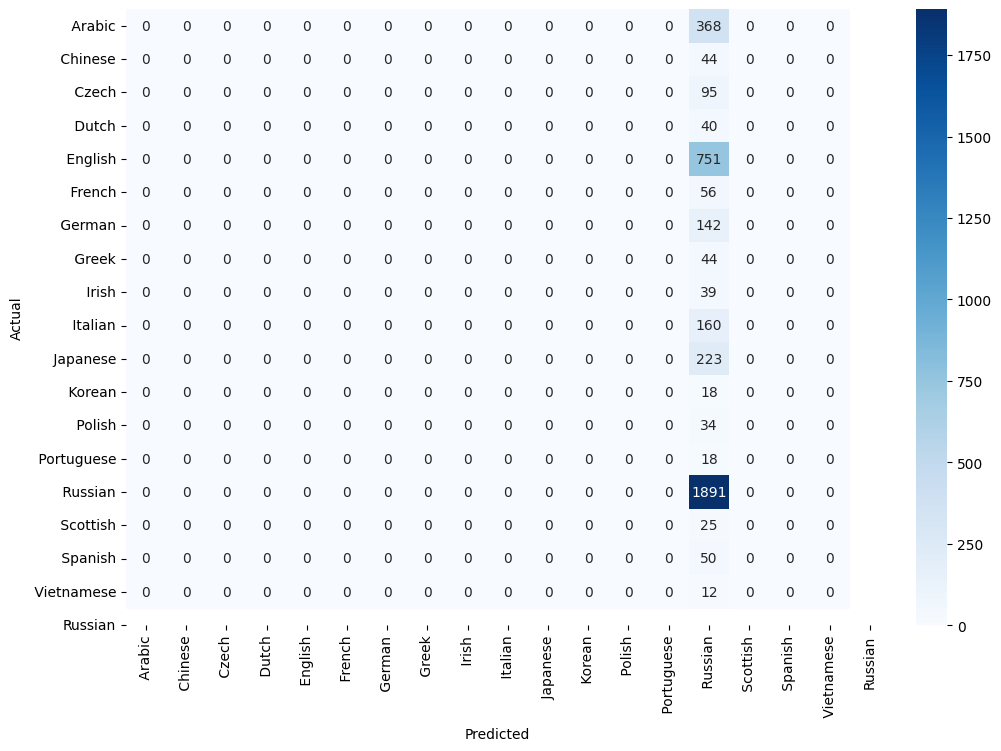

Training LSTM...
Epoch 1/10, Loss: 0.9582
Epoch 2/10, Loss: 0.2738
Epoch 3/10, Loss: 0.6591
Epoch 4/10, Loss: 0.7708
Epoch 5/10, Loss: 0.4578
Epoch 6/10, Loss: 0.2828
Epoch 7/10, Loss: 0.2161
Epoch 8/10, Loss: 0.5146
Epoch 9/10, Loss: 0.3671
Epoch 10/10, Loss: 0.0099
Test Accuracy: 0.8307


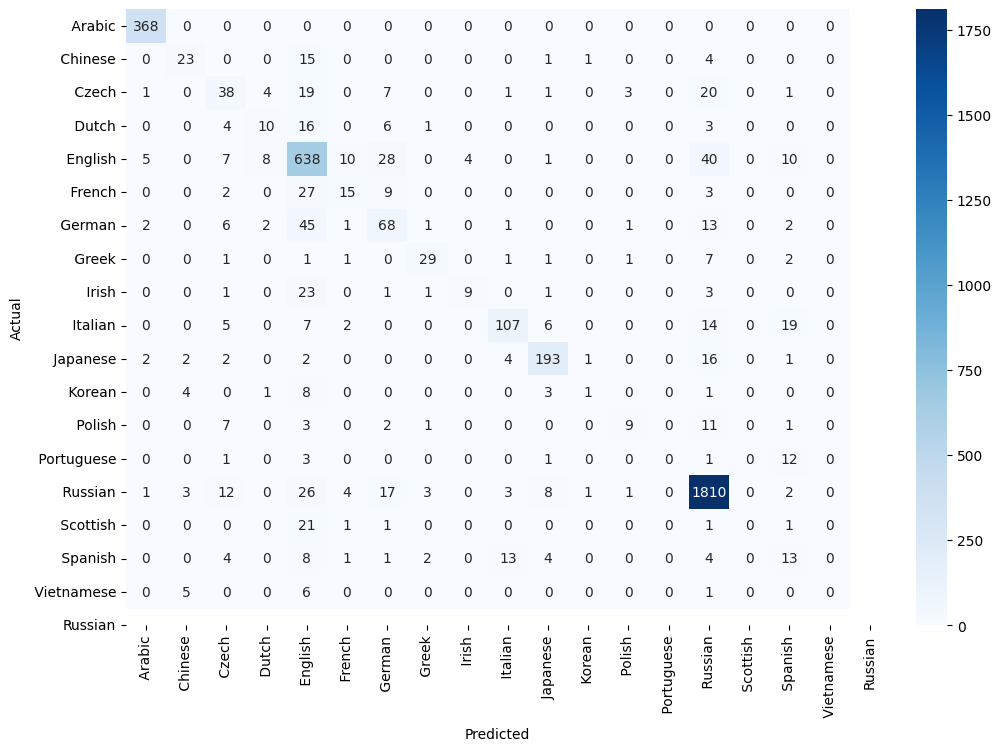

Training GRU...
Epoch 1/10, Loss: 0.7464
Epoch 2/10, Loss: 0.5288
Epoch 3/10, Loss: 0.7930
Epoch 4/10, Loss: 0.3751
Epoch 5/10, Loss: 0.0591
Epoch 6/10, Loss: 0.4658
Epoch 7/10, Loss: 0.6566
Epoch 8/10, Loss: 0.5106
Epoch 9/10, Loss: 0.9640
Epoch 10/10, Loss: 0.1485
Test Accuracy: 0.8282


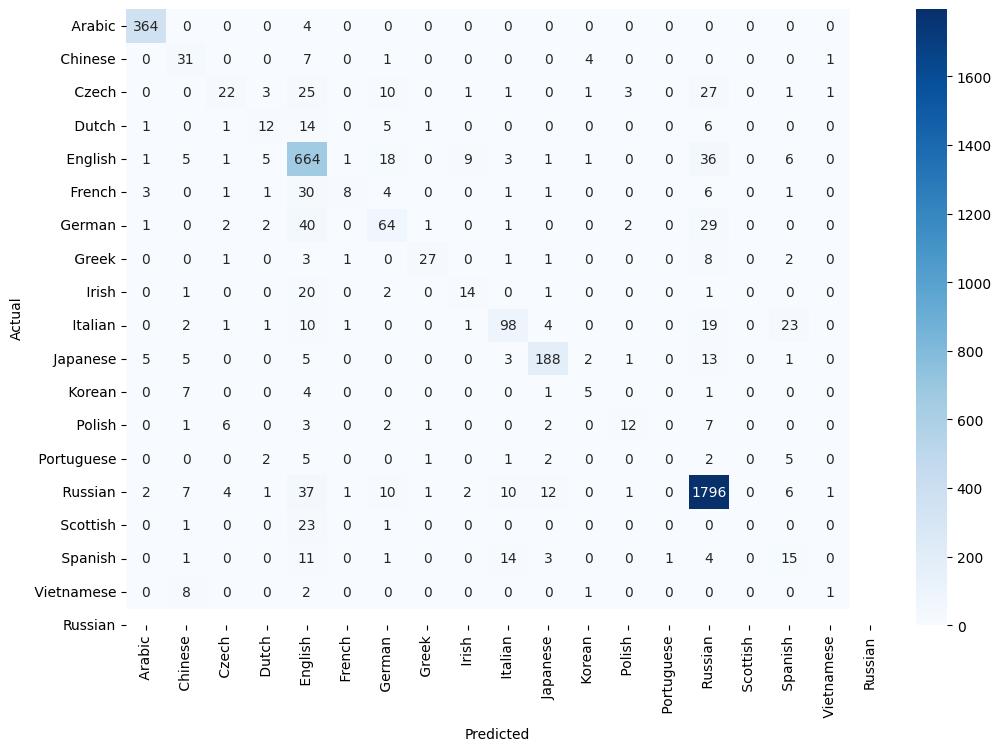


RNN Accuracy: 0.4716
LSTM Accuracy: 0.8307
GRU Accuracy: 0.8282


In [5]:

hidden_size = 128
output_size = len(le.classes_)

rnn_model = NameRNN(n_letters+1, hidden_size, output_size, model_type='RNN')
print("Training RNN...")
rnn_acc = train_model(rnn_model, train_loader, test_loader)


lstm_model = NameRNN(n_letters+1, hidden_size, output_size, model_type='LSTM')
print("Training LSTM...")
lstm_acc = train_model(lstm_model, train_loader, test_loader)


gru_model = NameRNN(n_letters+1, hidden_size, output_size, model_type='GRU')
print("Training GRU...")
gru_acc = train_model(gru_model, train_loader, test_loader)


print(f"\nRNN Accuracy: {rnn_acc:.4f}")
print(f"LSTM Accuracy: {lstm_acc:.4f}")
print(f"GRU Accuracy: {gru_acc:.4f}")


In [6]:
def predict_language(model, name, max_len=20):
    model.eval()
    seq = torch.tensor([name_to_sequence(name, max_len)], dtype=torch.long).to(device)
    with torch.no_grad():
        output = model(seq)
        pred_idx = torch.argmax(output, dim=1).item()
        language = le.inverse_transform([pred_idx])[0]
    return language


In [7]:
random_names = ["Abreu", "Casey", "Thi", "Mulder", "Abaroa"]

print("\nRNN Predictions:")
for name in random_names:
    print(f"{name} -> {predict_language(rnn_model, name)}")

print("\nLSTM Predictions:")
for name in random_names:
    print(f"{name} -> {predict_language(lstm_model, name)}")

print("\nGRU Predictions:")
for name in random_names:
    print(f"{name} -> {predict_language(gru_model, name)}")



RNN Predictions:
Abreu ->  Russian
Casey ->  Russian
Thi ->  Russian
Mulder ->  Russian
Abaroa ->  Russian

LSTM Predictions:
Abreu ->  Spanish
Casey ->  English
Thi ->  Chinese
Mulder ->  English
Abaroa ->  Spanish

GRU Predictions:
Abreu ->  Spanish
Casey ->  English
Thi ->  Korean
Mulder ->  English
Abaroa ->  Spanish
